# Transfer Learning with TensorFlow Part 2: Fine-tuning

In the previous section, we saw how we could leverage feature extraction transfer learning to get far better results on our Food Vision project than building our own models (even with less data).

Now we're going to cover another type of transfer learning: fine-tuning.

In fine-tuning transfer learning the pre-trained model weights from another model are unfrozen and tweaked during to better suit your own data.

For feature extraction transfer learning, you may only train the top 1-3 layers of a pre-trained model with your own data, in fine-tuning transfer learning, you might train 1-3+ layers of a pre-trained model (where the '+' indicates that many or all of the layers could be trained).

 Feature extraction transfer learning vs. fine-tuning transfer learning. The main difference between the two is that in fine-tuning, more layers of the pre-trained model get unfrozen and tuned on custom data. This fine-tuning usually takes more data than feature extraction to be effective.

 ## What we're going to cover
We're going to go through the follow with TensorFlow:

* Introduce fine-tuning, a type of transfer learning to modify a pre-trained model to be more suited to your data
* Using the Keras Functional API (a differnt way to build models in Keras)
* Using a smaller dataset to experiment faster (e.g. 1-10% of training samples of 10 classes of food)
* Data augmentation (how to make your training dataset more diverse without adding more data)
* Running a series of modelling experiments on our Food Vision data
    1. Model 0: a transfer learning model using the Keras Functional API
    2. Model 1: a feature extraction transfer learning model on 1% of the data with data augmentation
    3. Model 2: a feature extraction transfer learning model on 10% of the data with data augmentation
    4. Model 3: a fine-tuned transfer learning model on 10% of the data
    5. Model 4: a fine-tuned transfer learning model on 100% of the data
* Introduce the ModelCheckpoint callback to save intermediate training results
* Compare model experiments results using TensorBoard

In [112]:
!nvidia-smi

Sat Jan 13 14:02:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0              31W /  70W |   4221MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 10 Food Classes: Working with less data

We saw in the previous notebook that we could get great results with only 10% of the training data using transfer learning with TensorFlow Hub.

In this notebook, we're going to continue to work with smaller subsets of the data, except this time we'll have a look at how we can use the in-built pretrained models within the **`tf.keras.applications`** module as well as how to fine-tune them to our own custom dataset.

We'll also practice using a new but similar dataloader function to what we've used before, **`image_dataset_from_directory()`** which is part of the **`tf.keras.utils`** module.

Finally, we'll also be practicing using the Keras Functional API for building deep learning models. The Functional API is a more flexible way to create models than the **`tf.keras.Sequential`** API.

We'll explore each of these in more detail as we go.

Let's start by downloading some data.

In [113]:
# import heleper function we're going to use
from drive.MyDrive.help import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [114]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2024-01-13 14:02:03--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.207, 173.194.69.207, 173.194.79.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.4’

10_food_classes_10_ 100%[===================>] 160.74M  41.1MB/s    in 4.5s    

2024-01-13 14:02:08 (35.8 MB/s) - ‘10_food_classes_10_percent.zip.4’ saved [168546183/168546183]



In [115]:
walk_through_dir('10_food_classes_10_percent2')

In [116]:
train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

In [117]:
import tensorflow as tf

IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='categorical',
                                                                            batch_size=32)
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode='categorical',
                                                                           batch_size=32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [118]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In the above output:

* `(None, 224, 224, 3)` refers to the tensor shape of our images where None is the batch size, 224 is the height (and width) and 3 is the color channels (red, green, blue).
* `(None, 10)` refers to the tensor shape of the labels where None is the batch size and 10 is the number of possible labels (the 10 different food classes).
* Both image tensors and labels are of the datatype tf.float32.
The `batch_size` is `None` due to it only being used during model training. You can think of None as a placeholder waiting to be filled with the `batch_size` parameter from **`image_dataset_from_directory()`**.

Another benefit of using the `tf.data.Dataset` API are the assosciated methods which come with it.

For example, if we want to find the name of the classes we were working with, we could use the **`class_names`** attribute.

In [119]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [120]:
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[4.35714293e+00 6.35714293e+00 4.43571434e+01]
   [3.00000000e+00 5.00000000e+00 4.30000000e+01]
   [4.78571415e+00 6.78571415e+00 4.47857132e+01]
   ...
   [8.28061962e+00 1.02806196e+01 4.90663567e+01]
   [8.35714245e+00 1.03571424e+01 4.93571434e+01]
   [7.35714293e+00 9.35714245e+00 4.83571434e+01]]

  [[4.35714293e+00 6.35714293e+00 4.43571434e+01]
   [3.00000000e+00 5.00000000e+00 4.30000000e+01]
   [4.78571415e+00 6.78571415e+00 4.47857132e+01]
   ...
   [7.98469543e+00 9.98469543e+00 4.79846954e+01]
   [7.92855835e+00 9.92855835e+00 4.89285583e+01]
   [6.00000000e+00 8.00000000e+00 4.70000000e+01]]

  [[6.35714293e+00 6.35714293e+00 4.43571434e+01]
   [5.00000000e+00 5.00000000e+00 4.30000000e+01]
   [6.78571415e+00 6.78571415e+00 4.47857132e+01]
   ...
   [9.78571415e+00 1.17857141e+01 4.97857132e+01]
   [8.71427250e+00 1.07142725e+01 4.94999847e+01]
   [6.50507450e+00 8.50507450e+00 4.72907906e+01]]

  ...

  [[1.94724518e+02 5.68674622e+01 4.27958374e+01]
   [1

## Model 0: Building a transfer learning model using the Keras Functional API

Alright, our data is tensor-ified, let's build a model.

To do so we're going to be using the tf.keras.applications module as it contains a series of already trained (on ImageNet) computer vision models as well as the Keras Functional API to construct our model.

In [121]:
# 1 create the baseline model wth tf.keras.application
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# freez the baseline model
base_model.trainable = False

# create the input into base model
input = tf.keras.layers.Input(shape=(224, 224, 3), name='Input layer')

# pas the input into base model
x = base_model(input)

# average pool the output of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

# ouptut layer
output = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# create the first model
model_0 = tf.keras.Model(input, output)

# compile the model
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# fit the model

history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 validation_steps=len(test_data_10_percent),
                                 )


Epoch 1/5
24/24 [==============================] - 19s 443ms/step - loss: 1.8928 - accuracy: 0.4333 - val_loss: 1.3146 - val_accuracy: 0.7312
Epoch 2/5
24/24 [==============================] - 7s 281ms/step - loss: 1.1485 - accuracy: 0.7400 - val_loss: 0.8968 - val_accuracy: 0.8092
Epoch 3/5
24/24 [==============================] - 7s 284ms/step - loss: 0.8385 - accuracy: 0.8147 - val_loss: 0.7165 - val_accuracy: 0.8416
Epoch 4/5
24/24 [==============================] - 12s 505ms/step - loss: 0.6771 - accuracy: 0.8600 - val_loss: 0.6244 - val_accuracy: 0.8480
Epoch 5/5
24/24 [==============================] - 8s 314ms/step - loss: 0.5983 - accuracy: 0.8587 - val_loss: 0.5663 - val_accuracy: 0.8508


In [122]:
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 6s 66ms/step - loss: 0.5663 - accuracy: 0.8508


[0.5663383603096008, 0.8507999777793884]

In [123]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_9
1 rescaling_8
2 normalization_8
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 b

In [124]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_8 (Rescaling)     (None, None, None, 3)        0         ['input_9[0][0]']             
                                                                                                  
 normalization_8 (Normaliza  (None, None, None, 3)        0         ['rescaling_8[0][0]']         
 tion)                                                                                            
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [125]:
model_0.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
________________

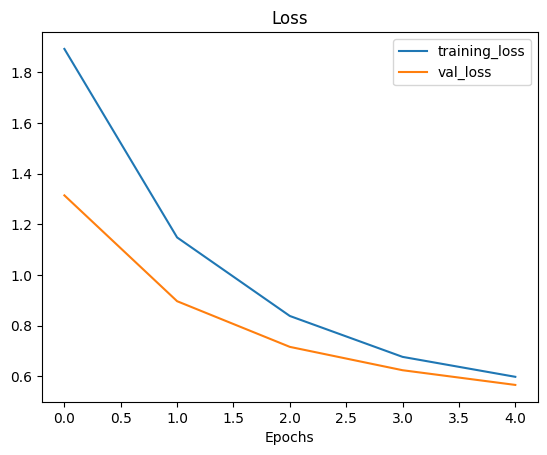

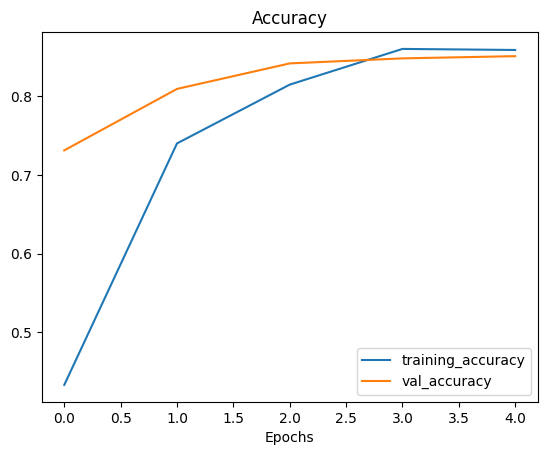

In [126]:
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

The **`tf.keras.layers.GlobalAveragePooling2D()`** layer transforms a 4D tensor into a 2D tensor by averaging the values across the inner-axes.

In [127]:
input_shape = (1, 4, 4, 3)

# create the random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f'Random input:\n {input_tensor}\n')

global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

Random input:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


In [128]:
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a series of transfer learning experiments

We've seen the incredible results of transfer learning on 10% of the training data, what about 1% of the training data?

What kind of results do you think we can get using 100x less data than the original CNN models we built ourselves?

Why don't we answer that question while running the following modelling experiments:

1. Model 1: Use feature extraction transfer learning on 1% of the training data with data augmentation.
2. Model 2: Use feature extraction transfer learning on 10% of the training data with data augmentation and save the results to a checkpoint.
3. Model 3: Fine-tune the Model 2 checkpoint on 10% of the training data with data augmentation.
4. Model 4: Fine-tune the Model 2 checkpoint on 100% of the training data with data augmentation.



While all of the experiments will be run on different versions of the training data, they will all be evaluated on the same test dataset, this ensures the results of each experiment are as comparable as possible.

All experiments will be done using the **EfficientNetV2B0** model within the `tf.keras.applications.efficientnet_v2 module.`

To make sure we're keeping track of our experiments, we'll use our create_tensorboard_callback() function to log all of the model training logs.

We'll construct each model using the Keras Functional API and instead of implementing data augmentation in the ImageDataGenerator class as we have previously, we're going to build it right into the model using the tf.keras.layers module.

Let's begin by downloading the data for experiment 1, using feature extraction transfer learning on 1% of the training data with data augmentation.

In [129]:
# download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data('10_food_classes_1_percent.zip')

--2024-01-13 14:03:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.96.207, 108.177.119.207, 108.177.127.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.96.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.2’

10_food_classes_1_p 100%[===================>] 127.42M  38.1MB/s    in 3.7s    

2024-01-13 14:03:48 (34.6 MB/s) - ‘10_food_classes_1_percent.zip.2’ saved [133612354/133612354]



In [130]:
train_dir_1_percent = '/content/10_food_classes_1_percent/train/'
test_dir_1_percent = '/content/10_food_classes_1_percent/test/'

In [131]:
walk_through_dir('/content/10_food_classes_1_percent')

There are 2 directories and 0 images in '/content/10_food_classes_1_percent'.
There are 10 directories and 0 images in '/content/10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/steak'

In [132]:
import tensorflow as tf

IMAGE_SIZE = (224, 224)

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode='categorical',
                                                                           batch_size=32,
                                                                           image_size=IMAGE_SIZE)
test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir_1_percent,
                                                                          label_mode='categorical',
                                                                          batch_size=32,
                                                                          image_size=IMAGE_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

Previously we've used the different parameters of the ImageDataGenerator class to augment our training images, this time we're going to build data augmentation right into the model.

How?

Using the tf.keras.layers module and creating a dedicated data augmentation layer.

This a relatively new feature added to TensorFlow 2.10+ but it's very powerful. Adding a data augmentation layer to the model has the following benefits:

* Preprocessing of the images (augmenting them) happens on the GPU rather than on the CPU (much faster).
    * Images are best preprocessed on the GPU where as text and structured data are more suited to be preprocessed on the CPU.
* Image data augmentation only happens during training so we can still export our whole model and use it elsewhere. And if someone else wanted to train the same model as us, including the same kind of data augmentation, they could.


To use data augmentation right within our model we'll create a Keras Sequential model consisting of only data preprocessing layers, we can then use this Sequential model within another Functional model.

If that sounds confusing, it'll make sense once we create it in code.

The data augmentation transformations we're going to use are:

1. **`tf.keras.layers.RandomFlip`** - flips image on horizontal or vertical axis.
2. **`tf.keras.layersRandomRotation`** - randomly rotates image by a specified amount.
3. **`tf.keras.layers.RandomZoom`** - randomly zooms into an image by specified amount.
4. **`tf.keras.layers.RandomHeight`** - randomly shifts image height by a specified amount.
5. **`tf.keras.layers.RandomWidth`** - randomly shifts image width by a specified amount.
6. **`tf.keras.layers.Rescaling`** - normalizes the image pixel values to be between 0 and 1, this is worth mentioning because it is required for some image models but since we're using **`tf.keras.applications.efficientnet_v2.EfficientNetV2B0`**, it's not required (the model pretrained model implements rescaling itself).
There are more option but these will do for now.

In [133]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
], name='data_augmentation')

(-0.5, 415.5, 310.5, -0.5)

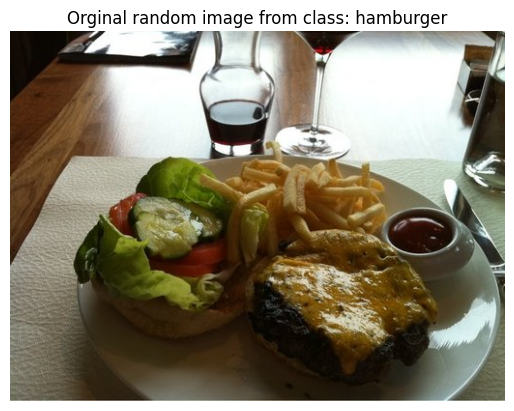

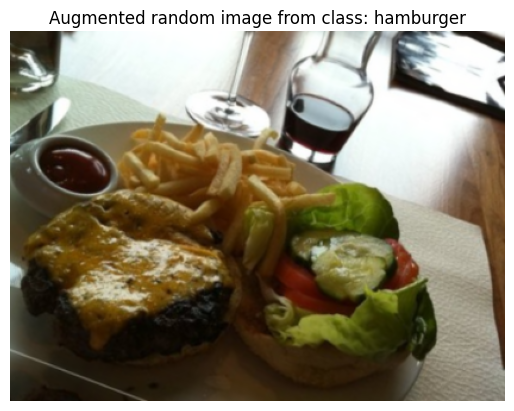

In [134]:
# view random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = '/content/10_food_classes_1_percent/train/' + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + '/' + random_image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f'Orginal random image from class: {target_class}')
plt.axis(False)

# augmented the image
augmented_image = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_image)/255.)
plt.title(f'Augmented random image from class: {target_class}')
plt.axis(False)

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [135]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model_1 = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model_1.trainable = False

# create input layer
input = tf.keras.layers.Input(shape=input_shape, name='input_layer')

# add in data augmentation Sequential model as a layer
x = data_augmentation(input)

# give the base model inputs
x = base_model_1(x, training=False)

# pool output features of base model
x = tf.keras.layers.GlobalAveragePooling2D(name='Global_average_pool_layer')(x)

# put a dense layer on as the poutput
output = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# make a model with input and output
model_1 = tf.keras.Model(input, output)

# compile the model
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data_1_percent,
                                validation_steps=int(0.25 * len(test_data_1_percent)))

Epoch 1/5
3/3 [==============================] - 15s 3s/step - loss: 2.3551 - accuracy: 0.1571 - val_loss: 2.2385 - val_accuracy: 0.1809
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.1498 - accuracy: 0.2429 - val_loss: 2.1270 - val_accuracy: 0.2566
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 1.8795 - accuracy: 0.4714 - val_loss: 2.0212 - val_accuracy: 0.3339
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.8026 - accuracy: 0.5571 - val_loss: 1.9296 - val_accuracy: 0.4211
Epoch 5/5
3/3 [==============================] - 7s 3s/step - loss: 1.6545 - accuracy: 0.5857 - val_loss: 1.8286 - val_accuracy: 0.4638


In [136]:
model_1.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 Global_average_pool_layer   (None, 1280)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

In [137]:
result_1_percent_data_aug = model_1.evaluate(test_data_1_percent)
result_1_percent_data_aug

79/79 [==============================] - 6s 66ms/step - loss: 1.8309 - accuracy: 0.4708


[1.830871820449829, 0.4708000123500824]

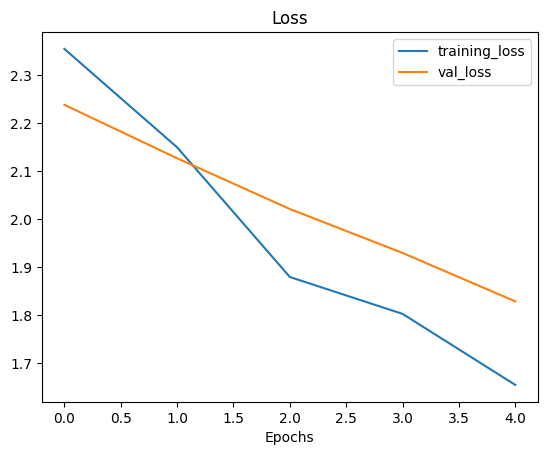

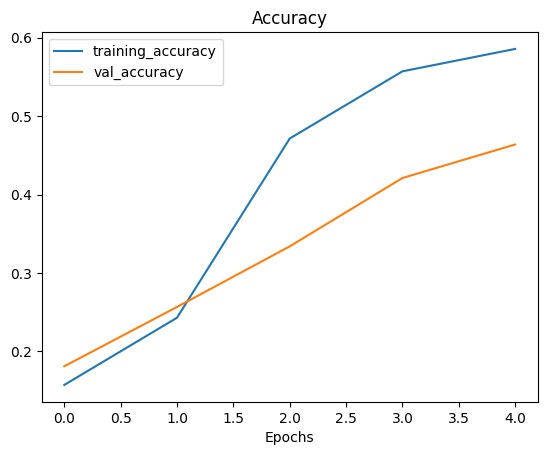

In [138]:
plot_loss_curves(history_1_percent)

## Model 2: Feature extraction transfer learning with 10% of data and data augmentation

The truth here is you often won't. Machine learning is still a very experimental practice. It's only after trying a fair few things that you'll start to develop an intuition of what to try.

My advice is to follow your curiosity as tenaciously as possible. If you feel like you want to try something, write the code for it and run it. See how it goes. The worst thing that'll happen is you'll figure out what doesn't work, the most valuable kind of knowledge.

From a practical standpoint, as we've talked about before, you'll want to reduce the amount of time between your initial experiments as much as possible. In other words, run a plethora of smaller experiments, using less data and less training iterations before you find something promising and then scale it up.

In the theme of scale, let's scale our 1% training data augmentation experiment up to 10% training data augmentation. That sentence doesn't really make sense but you get what I mean.

We're going to run through the exact same steps as the previous model, the only difference being using 10% of the training data instead of 1%.

In [139]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data('10_food_classes_10_percent.zip')

--2024-01-13 14:04:55--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.96.207, 108.177.119.207, 108.177.127.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.96.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.5’

10_food_classes_10_ 100%[===================>] 160.74M  41.9MB/s    in 4.4s    

2024-01-13 14:04:59 (36.3 MB/s) - ‘10_food_classes_10_percent.zip.5’ saved [168546183/168546183]



In [140]:
train_dir_10_percent = '/content/10_food_classes_10_percent/train/'
test_dir_10_percent = '/content/10_food_classes_10_percent/test/'

In [141]:
import tensorflow as tf

IMG_SIZE = (224, 224)
train_data_10_percent_2 = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                              label_mode='categorical',
                                                                              batch_size=32,
                                                                              image_size=IMG_SIZE)
test_data_10_percent_2 = tf.keras.preprocessing.image_dataset_from_directory(test_dir_10_percent,
                                                                             label_mode='categorical',
                                                                             batch_size=32,
                                                                             image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [142]:
# # Create a functional model with data augmentation
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# data augmentation
data_augmentation_1 = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
], name='Data_augmentation')


# setup input shape
input_shape = (224, 224, 3)

# create a frozen base model
base_model_2 = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model_2.trainable = False

# create input and output layers
input = tf.keras.layers.Input(shape=input_shape, name='input_layer')
x = data_augmentation_1(input)
x = base_model_1(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pool_layer')(x)
output = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)
model_2 = tf.keras.Model(input, output)

# compile the model
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])



To save time for later (when we want to perform multiple experiments with model_2), let's put the code above into a function we can resuse.

In [143]:
def create_base_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                      output_shape: int = 10,
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:
    """
    Create a model based on EfficientNetV2B0 with built-in data augmentation.

    Parameters:
    - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
    - output_shape (int): Number of classes for the output layer. Default is 10.
    - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
    - training (bool): Whether the base model is trainable. Default is False.

    Returns:
    - tf.keras.Model: The compiled model with specified input and output settings.
    """

    # Create base model
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    base_model.trainable = training

    # Setup model input and outputs with data augmentation built-in
    inputs = layers.Input(shape=input_shape, name="input_layer")
    x = data_augmentation(inputs)
    x = base_model(x, training=False)  # pass augmented images to base model but keep it in inference mode
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs)

    # Compile model
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    return model

# Create an instance of model_2 with our new function
model_2 = create_base_model()

## Creating a ModelCheckpoint callback

In [144]:
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [145]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent_2,
                                          epochs=initial_epochs,
                                          validation_data=test_data_10_percent_2,
                                          validation_steps=int(0.25 * len(test_data_10_percent_2)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"),
                                                     checkpoint_callback])


Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20240113-140511
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9965 - accuracy: 0.3693
Epoch 1: val_loss improved from inf to 1.42077, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 32s 883ms/step - loss: 1.9965 - accuracy: 0.3693 - val_loss: 1.4208 - val_accuracy: 0.6595
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3784 - accuracy: 0.6680
Epoch 2: val_loss improved from 1.42077 to 1.02500, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 17s 667ms/step - loss: 1.3784 - accuracy: 0.6680 - val_loss: 1.0250 - val_accuracy: 0.7780
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0867 - accuracy: 0.7360
Epoch 3: val_loss improved from 1.02500 to 0.80596, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [=

In [146]:
results_10_percent_data_aug = model_2.evaluate(test_data_10_percent_2)
results_10_percent_data_aug

79/79 [==============================] - 8s 92ms/step - loss: 0.6461 - accuracy: 0.8340


[0.6460754871368408, 0.8339999914169312]

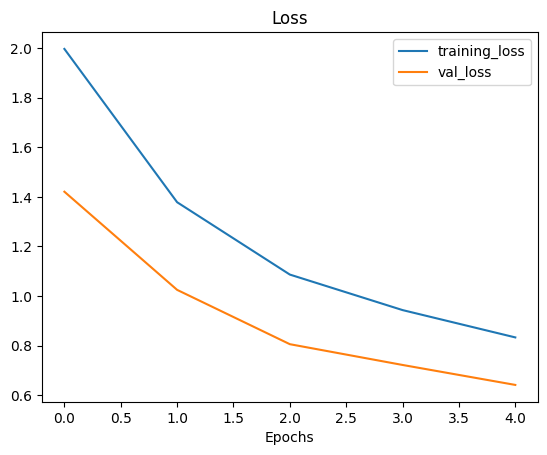

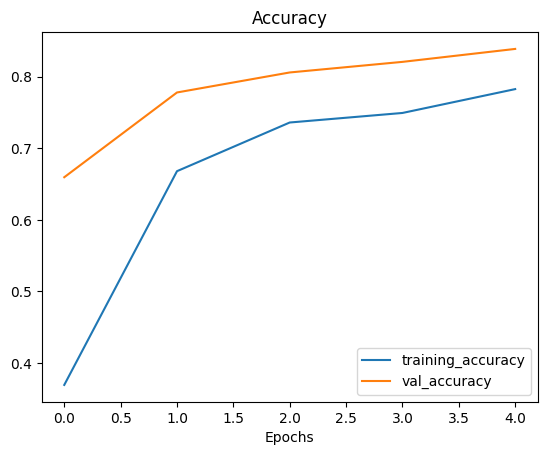

In [147]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

In [148]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data_10_percent_2)

79/79 [==============================] - 5s 63ms/step - loss: 0.6461 - accuracy: 0.8340


In [149]:
# If the results from our native model and the loaded weights are the same, this should output True
results_10_percent_data_aug == loaded_weights_model_results

False

In [150]:
import numpy as np
# Check to see if loaded model results are very close to native model results (should output True)
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))


array([ True,  True])

In [151]:
# Check the difference between the two results (small values)
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))


[-1.1920929e-07  0.0000000e+00]


## Model 3: Fine-tuning an existing model on 10% of the data

 High-level example of fine-tuning an EfficientNet model. Bottom layers (layers closer to the input data) stay frozen where as top layers (layers closer to the output data) are updated during training.

So far our saved model has been trained using feature extraction transfer learning for 5 epochs on 10% of the training data and data augmentation.

This means all of the layers in the base model **`(EfficientNetV2B0)`** were frozen during training.

For our next experiment we're going to switch to fine-tuning transfer learning. This means we'll be using the same base model except we'll be unfreezing some of its layers (ones closest to the top) and running the model for a few more epochs.

The idea with fine-tuning is to start customizing the pre-trained model more to our own data.

In [152]:
model_2.layers

In [153]:
for layer_number, layer in enumerate(model_2.layers):
  print(f'''1-layer number: {layer_number}
2-layer name: {layer.name}
3-layer type: {layer}
4-is trainable ? {layer.trainable}
****************************************''')

1-layer number: 0
2-layer name: input_layer
3-layer type: <keras.src.engine.input_layer.InputLayer object at 0x7c4d04401960>
4-is trainable ? True
****************************************
1-layer number: 1
2-layer name: data_augmentation
3-layer type: <keras.src.engine.sequential.Sequential object at 0x7c4cfcebcb50>
4-is trainable ? True
****************************************
1-layer number: 2
2-layer name: efficientnetv2-b0
3-layer type: <keras.src.engine.functional.Functional object at 0x7c4cff889000>
4-is trainable ? False
****************************************
1-layer number: 3
2-layer name: global_average_pooling_layer
3-layer type: <keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7c4d053fab60>
4-is trainable ? True
****************************************
1-layer number: 4
2-layer name: output_layer
3-layer type: <keras.src.layers.core.dense.Dense object at 0x7c4d13c045b0>
4-is trainable ? True
****************************************


In [154]:
model_2.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                128

In [155]:
model_2_base_model = model_2.layers[2]
model_2_base_model.name

'efficientnetv2-b0'

In [156]:
print(len(model_2_base_model.trainable_variables))

0


In [157]:
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_12 False
1 rescaling_11 False
2 normalization_11 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwcon

In [167]:
# make all the layer in model_2_base_model trainable
model_2_base_model.trainable = True

for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False

# recompile the model
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

In [159]:
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_12 False
1 rescaling_11 False
2 normalization_11 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwcon

In [160]:
print(len(model_2.trainable_variables))

12


In [168]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent_2,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data_10_percent_2,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data_10_percent_2)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]) # name experiment appropriately


Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20240113-141633
Epoch 5/10
24/24 [==============================] - 31s 801ms/step - loss: 0.6972 - accuracy: 0.8040 - val_loss: 0.4963 - val_accuracy: 0.8487
Epoch 6/10
24/24 [==============================] - 20s 781ms/step - loss: 0.6203 - accuracy: 0.8067 - val_loss: 0.4733 - val_accuracy: 0.8454
Epoch 7/10
24/24 [==============================] - 15s 586ms/step - loss: 0.5304 - accuracy: 0.8400 - val_loss: 0.4579 - val_accuracy: 0.8470
Epoch 8/10
24/24 [==============================] - 12s 506ms/step - loss: 0.4933 - accuracy: 0.8467 - val_loss: 0.4736 - val_accuracy: 0.8470
Epoch 9/10
24/24 [==============================] - 11s 443ms/step - loss: 0.4731 - accuracy: 0.8480 - val_loss: 0.4755 - val_accuracy: 0.8520
Epoch 10/10
24/24 [==============================] - 14s 573ms/step - loss: 0.4541 - accuracy: 0.8573 - val_loss: 0.4244 - val_accuracy: 0.8536


In [169]:
result_fine_tune_10_percent = model_2.evaluate(test_data_10_percent_2)

79/79 [==============================] - 6s 67ms/step - loss: 0.4284 - accuracy: 0.8600


In [170]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.36933332681655884, 0.6679999828338623, 0.7360000014305115, 0.7493333220481873, 0.7826666831970215, 0.8040000200271606, 0.8066666722297668, 0.8399999737739563, 0.846666693687439, 0.8479999899864197, 0.8573333621025085]


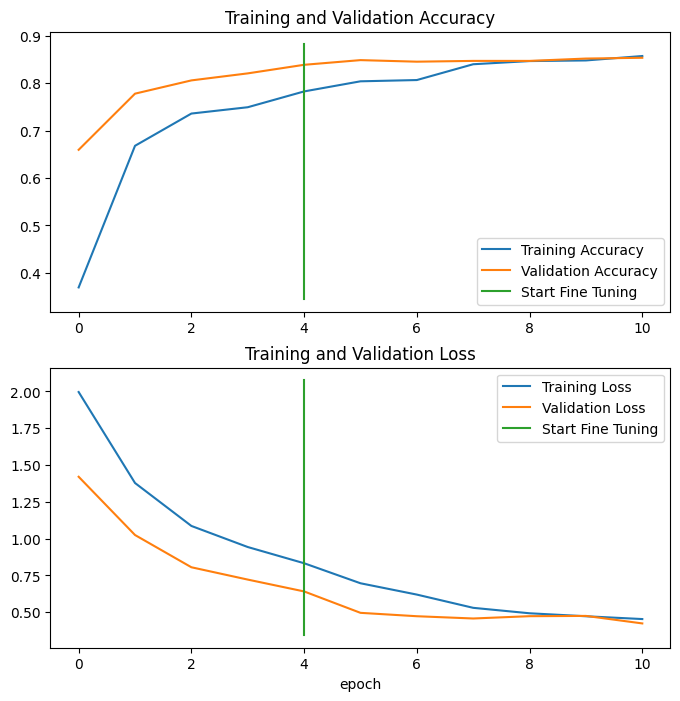

In [171]:
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_percent_data_aug,
                 initial_epochs=5)

## Model 4: Fine-tuning an existing model all of the data

In [172]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2024-01-13 14:21:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.96.207, 108.177.119.207, 108.177.127.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.96.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  28.3MB/s    in 19s     

2024-01-13 14:21:31 (26.1 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [173]:
train_dir = '/content/10_food_classes_all_data/train/'
test_dir = '/content/10_food_classes_all_data/test/'

In [174]:
walk_through_dir('/content/10_food_classes_all_data')

There are 2 directories and 0 images in '/content/10_food_classes_all_data'.
There are 10 directories and 0 images in '/content/10_food_classes_all_data/train'.
There are 0 directories and 750 images in '/content/10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '/content/10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '/content/10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '/content/10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '/content/10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '/content/10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '/content/10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '/content/10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '/content/10_food_classes_all_data/train

In [175]:
# set up data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_class_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                               label_mode='categorical',
                                                                               image_size=IMG_SIZE)
test_data_10_class_full = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                              label_mode='categorical',
                                                                              image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [176]:
# Evaluate model (this is the fine-tuned 10 percent of data version)
model_2.evaluate(test_data_10_class_full)

79/79 [==============================] - 10s 102ms/step - loss: 0.4284 - accuracy: 0.8600


[0.42838871479034424, 0.8600000143051147]

In [177]:
result_fine_tune_10_percent

[0.4283886253833771, 0.8600000143051147]

In [178]:
# create the new instance of model_2 for experiment
model_2 = create_base_model(learning_rate=0.0001)

In [179]:
model_2.load_weights(checkpoint_path)

In [180]:
model_2.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                128

In [181]:
print(len(model_2.trainable_variables))

2


In [182]:
model_2.evaluate(test_data_10_class_full)

79/79 [==============================] - 10s 65ms/step - loss: 0.6461 - accuracy: 0.8340


[0.6460756063461304, 0.8339999914169312]

In [183]:
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetv2-b0 False
3 global_average_pooling_layer True
4 output_layer True


In [186]:
model_2_base_model = model_2.layers[2]
model_2_base_model.trainable = True

# freez all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False

In [188]:
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_13 False
1 rescaling_12 False
2 normalization_12 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwcon

In [189]:
# compile our model
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

In [190]:
fine_tune_epoch = initial_epochs + 5

history_fine_10_class_full = model_2.fit(train_data_10_class_full,
                                         epochs=fine_tune_epoch,
                                         initial_epoch=history_10_percent_data_aug.epoch[-1],
                                         validation_data=test_data_10_class_full,
                                         validation_steps=int(0.25 * len(test_data_10_class_full)),
                                         callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20240113-144337
Epoch 5/10
235/235 [==============================] - 118s 454ms/step - loss: 0.7216 - accuracy: 0.7667 - val_loss: 0.3701 - val_accuracy: 0.8668
Epoch 6/10
235/235 [==============================] - 91s 388ms/step - loss: 0.5962 - accuracy: 0.8061 - val_loss: 0.3190 - val_accuracy: 0.8964
Epoch 7/10
235/235 [==============================] - 80s 339ms/step - loss: 0.5515 - accuracy: 0.8189 - val_loss: 0.3106 - val_accuracy: 0.9013
Epoch 8/10
235/235 [==============================] - 70s 297ms/step - loss: 0.5082 - accuracy: 0.8313 - val_loss: 0.3020 - val_accuracy: 0.9112
Epoch 9/10
235/235 [==============================] - 67s 282ms/step - loss: 0.4891 - accuracy: 0.8391 - val_loss: 0.2698 - val_accuracy: 0.9128
Epoch 10/10
235/235 [==============================] - 60s 250ms/step - loss: 0.4575 - accuracy: 0.8511 - val_loss: 0.2791 - val_accuracy: 0.9112


In [191]:
result_fine_tune_full_data = model_2.evaluate(test_data_10_class_full)

79/79 [==============================] - 6s 65ms/step - loss: 0.2709 - accuracy: 0.9152


In [192]:
result_fine_tune_full_data

[0.27085521817207336, 0.9151999950408936]

In [193]:
result_fine_tune_10_percent

[0.4283886253833771, 0.8600000143051147]

5
11
[0.36933332681655884, 0.6679999828338623, 0.7360000014305115, 0.7493333220481873, 0.7826666831970215, 0.7666666507720947, 0.8061333298683167, 0.8189333081245422, 0.831333339214325, 0.8390666842460632, 0.8510666489601135]


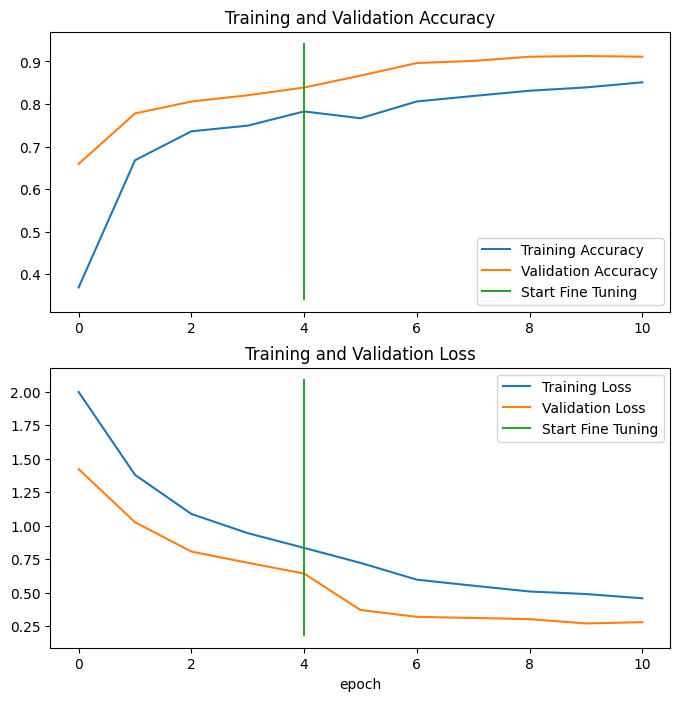

In [195]:
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_class_full,
                 initial_epochs=5)